IMPORTING PACKAGES



In [ ]:
# Importing necessary libraries
import pandas as pd                  # Pandas for data manipulation
import numpy as np                   # Numpy for numerical operations
from matplotlib import pyplot as plt # Matplotlib for data visualization
import sklearn

# Importing modules for Regression Tree Model
from sklearn.tree import DecisionTreeRegressor

# Package to implement Random Forest
from sklearn.ensemble import RandomForestClassifier

# Importing modules for Decision Tree Model
from sklearn.tree import DecisionTreeClassifier

# Importing modules for Grid Search Cross Validation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

# Importing modules for confusion matrix and classification report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# Importing module for recording time
import time

# Importing module for data pretty printer
from pprint import pprint

# Importing module to visualize Decision Tree
from sklearn import tree

# Displaying Matplotlib plots inline in the Jupyter Notebook
%matplotlib inline


DATA PREPROCESSING


In [ ]:
# Importing data from CSV files
games = pd.read_csv('games.csv')  # Reading game data
teams = pd.read_csv('teams.csv')  # Reading team data

# Removing the 'GAME_STATUS_TEXT' column from the 'games' dataframe
games.drop(columns='GAME_STATUS_TEXT', inplace=True)

# Creating separate DataFrames for home teams and away teams with team names and IDs
team_id = list(teams['TEAM_ID'])
team_name = list(teams['ABBREVIATION'])
hometeamsdf = pd.DataFrame({'HOME_TEAM_ID': team_id, 'HOME_TEAM': team_name})
awayteamsdf = pd.DataFrame({'VISITOR_TEAM_ID': team_id, 'VISITOR_TEAM': team_name})

# Merging the 'games' dataframe with the home and away team DataFrames based on team IDs
games_merge = pd.merge(pd.merge(games, hometeamsdf, on='HOME_TEAM_ID'), awayteamsdf, on='VISITOR_TEAM_ID')

# Filtering out rows where the home team's points ('PTS_home') is greater than 0
games_merge = games_merge[games_merge['PTS_home'] > 0]

# Assigning a binary variable 'home' with value 1 to indicate home games
games_merge['home'] = 1

# Dropping unnecessary columns from the merged dataframe
games_merge.drop(columns=['HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'TEAM_ID_home', 'TEAM_ID_away'], inplace=True)

# Sorting the dataframe by game date and resetting the index
games_merge.sort_values(by='GAME_DATE_EST', inplace=True)
games_merge.reset_index(inplace=True)
games_merge.drop(columns='index', inplace=True)

display(games_merge.head(5))

,GAME_DATE_EST,GAME_ID,SEASON,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS,HOME_TEAM,VISITOR_TEAM,home
0,2003-10-05,10300001,2003,90.0,0.457,0.735,0.143,23.0,41.0,85.0,0.447,0.500,0.250,20.0,38.0,1,UTA,DAL,1
1,2003-10-06,10300002,2003,105.0,0.494,0.618,0.267,25.0,48.0,94.0,0.427,0.700,0.154,20.0,43.0,1,MEM,MIL,1
2,2003-10-07,10300004,2003,99.0,0.488,0.667,0.167,20.0,52.0,89.0,0.408,0.727,0.350,15.0,34.0,1,DAL,ORL,1
3,2003-10-07,10300003,2003,96.0,0.391,0.600,0.444,19.0,37.0,100.0,0.494,0.690,0.667,25.0,52.0,0,DET,CLE,1
4,2003-10-07,10300005,2003,104.0,0.527,0.657,0.429,22.0,33.0,80.0,0.470,0.667,0.333,10.0,37.0,1,POR,HOU,1


ADDING FEATURES

In [ ]:
#Duplicating each row but switching stats to create Team vs opp instead of home vs away
#Ex: Row 1 = UTA vs DAL
#Now: Row 2 = DAL vs UTA

# Creating a copy of the original dataframe
games = games_merge
games_append_away = games.copy()

# Changing the 'home' column to 0 for the away team dataframe
games_append_away['home'] = 0

# Renaming columns to switch home stats with away stats
games_append_away.columns = ['GAME_DATE_EST', 'GAME_ID', 'SEASON', 'PTS_away', 'FG_PCT_away',
                              'FT_PCT_away', 'FG3_PCT_away', 'AST_away', 'REB_away', 'PTS_home', 'FG_PCT_home', 'FT_PCT_home',
                              'FG3_PCT_home', 'AST_home', 'REB_home', 'HOME_TEAM_WINS', 'VISITOR_TEAM', 'HOME_TEAM', 'home']

# Concatenating the original and modified dataframes to capture both perspectives
games_both = pd.concat([games, games_append_away])

# Sorting the combined dataframe by date and game ID and resetting the index
games_both.sort_values(by=['GAME_DATE_EST', 'GAME_ID'], inplace=True)
games_both.reset_index(inplace=True, drop=True)

# Renaming columns to reflect a "Team vs Opponent" perspective
games_both.rename(columns={'PTS_home': 'PTS', 'FG_PCT_home': 'FG_PCT', 'FT_PCT_home': 'FT_PCT', 'FG3_PCT_home': 'FG3_PCT',
                           'AST_home': 'AST', 'REB_home': 'REB', 'PTS_away': 'PTS_opp', 'FG_PCT_away': 'FG_PCT_opp',
                           'FT_PCT_away': 'FT_PCT_opp', 'FG3_PCT_away': 'FG3_PCT_opp', 'AST_away': 'AST_opp',
                           'REB_away': 'REB_opp', 'HOME_TEAM_WINS': 'WIN', 'HOME_TEAM': 'TEAM', 'VISITOR_TEAM': 'TEAM_opp'},
                  inplace=True)

# Recreating the logic for the 'WIN' column (1 for win, 0 for loss)
games_both['WIN'] = (games_both['PTS'] > games_both['PTS_opp']).astype(int)

# Creating a new column for point differential of each game (+ for win, - for loss)
games_both['diff'] = (games_both['PTS'] - games_both['PTS_opp']).astype(int)


display(games_both.head(5))

,GAME_DATE_EST,GAME_ID,SEASON,PTS,FG_PCT,FT_PCT,FG3_PCT,AST,REB,PTS_opp,FG_PCT_opp,FT_PCT_opp,FG3_PCT_opp,AST_opp,REB_opp,WIN,TEAM,TEAM_opp,home,diff
0,2003-10-05,10300001,2003,90.0,0.457,0.735,0.143,23.0,41.0,85.0,0.447,0.500,0.250,20.0,38.0,1,UTA,DAL,1,5
1,2003-10-05,10300001,2003,85.0,0.447,0.500,0.250,20.0,38.0,90.0,0.457,0.735,0.143,23.0,41.0,0,DAL,UTA,0,-5
2,2003-10-06,10300002,2003,105.0,0.494,0.618,0.267,25.0,48.0,94.0,0.427,0.700,0.154,20.0,43.0,1,MEM,MIL,1,11
3,2003-10-06,10300002,2003,94.0,0.427,0.700,0.154,20.0,43.0,105.0,0.494,0.618,0.267,25.0,48.0,0,MIL,MEM,0,-11
4,2003-10-07,10300003,2003,96.0,0.391,0.600,0.444,19.0,37.0,100.0,0.494,0.690,0.667,25.0,52.0,0,DET,CLE,1,-4


In [ ]:
# Function to add the target variable 'TARGET_WIN' representing the result of the next game (Win = 1, Loss = 0)
def add_target_win(team):
    team['TARGET_WIN'] = team['WIN'].shift(-1)
    return team

# Function to add the target variable 'TARGET_diff' representing the point differential of the next game
def add_target_diff(team):
    team['TARGET_diff'] = team['diff'].shift(-1)
    return team

# Applying the 'add_target_diff' function to calculate the point differential for the next game
games_both = games_both.groupby('TEAM', group_keys=False).apply(add_target_diff)

# Applying the 'add_target_win' function to calculate the result of the next game
games_both = games_both.groupby('TEAM', group_keys=False).apply(add_target_win)

# Handling missing values in the 'TARGET_WIN' column by assigning a value of 2
games_both['TARGET_WIN'][pd.isnull(games_both['TARGET_WIN'])] = 2


games_both

<ipython-input-4-24d98a816b24>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  games_both['TARGET_WIN'][pd.isnull(games_both['TARGET_WIN'])] = 2


,GAME_DATE_EST,GAME_ID,SEASON,PTS,FG_PCT,FT_PCT,FG3_PCT,AST,REB,PTS_opp,...,FG3_PCT_opp,AST_opp,REB_opp,WIN,TEAM,TEAM_opp,home,diff,TARGET_diff,TARGET_WIN
0,2003-10-05,10300001,2003,90.0,0.457,0.735,0.143,23.0,41.0,85.0,...,0.250,20.0,38.0,1,UTA,DAL,1,5,7.0,1.0
1,2003-10-05,10300001,2003,85.0,0.447,0.500,0.250,20.0,38.0,90.0,...,0.143,23.0,41.0,0,DAL,UTA,0,-5,10.0,1.0
2,2003-10-06,10300002,2003,105.0,0.494,0.618,0.267,25.0,48.0,94.0,...,0.154,20.0,43.0,1,MEM,MIL,1,11,-2.0,0.0
3,2003-10-06,10300002,2003,94.0,0.427,0.700,0.154,20.0,43.0,105.0,...,0.267,25.0,48.0,0,MIL,MEM,0,-11,-6.0,0.0
4,2003-10-07,10300003,2003,96.0,0.391,0.600,0.444,19.0,37.0,100.0,...,0.667,25.0,52.0,0,DET,CLE,1,-4,15.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53099,2022-12-21,22200476,2022,105.0,0.402,0.759,0.290,25.0,40.0,126.0,...,0.469,29.0,48.0,0,CHA,LAC,0,-21,NaN,2.0
53100,2022-12-22,22200477,2022,126.0,0.484,0.926,0.382,25.0,46.0,117.0,...,0.321,23.0,44.0,1,NOP,SAS,1,9,NaN,2.0
53101,2022-12-22,22200477,2022,117.0,0.478,0.815,0.321,23.0,44.0,126.0,...,0.382,25.0,46.0,0,SAS,NOP,0,-9,NaN,2.0
53102,2022-12-22,22200478,2022,120.0,0.488,0.952,0.457,16.0,40.0,112.0,...,0.333,20.0,37.0,1,UTA,WAS,1,8,NaN,2.0


In [ ]:
# Function to calculate rolling averages for the last 15 games' statistics
def find_team_averages(team):
    rolling = team.rolling(20).mean()
    return rolling

# Applying the rolling average function to the dataframe grouped by 'TEAM' and 'SEASON'
df_rolling_avg = games_both.groupby(['TEAM', 'SEASON'], group_keys=False).apply(find_team_averages)

# Displaying the dataframe with rolling averages
display(df_rolling_avg)


df_rolling_avg.columns

<ipython-input-5-81aa1f0cd01c>:3: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['GAME_DATE_EST', 'TEAM', 'TEAM_opp'], dtype='object')
  rolling = team.rolling(20).mean()


,GAME_ID,SEASON,PTS,FG_PCT,FT_PCT,FG3_PCT,AST,REB,PTS_opp,FG_PCT_opp,FT_PCT_opp,FG3_PCT_opp,AST_opp,REB_opp,WIN,home,diff,TARGET_diff,TARGET_WIN
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53099,22200322.90,2022.0,112.20,0.44845,0.75435,0.3171,23.70,45.75,120.50,0.49005,0.79320,0.37880,26.60,45.50,0.25,0.45,-8.30,NaN,0.35
53100,22200324.30,2022.0,117.30,0.48740,0.80260,0.3610,26.70,44.25,111.75,0.46200,0.75660,0.33905,24.75,42.80,0.65,0.70,5.55,NaN,0.75
53101,22200313.30,2022.0,109.25,0.46725,0.72570,0.3237,25.85,43.20,119.25,0.50440,0.78690,0.38470,26.35,43.55,0.25,0.55,-10.00,NaN,0.35
53102,22200345.15,2022.0,117.10,0.48080,0.76005,0.3776,24.85,42.30,118.30,0.49240,0.80945,0.36190,24.90,43.65,0.45,0.60,-1.20,NaN,0.55


Index(['GAME_ID', 'SEASON', 'PTS', 'FG_PCT', 'FT_PCT', 'FG3_PCT', 'AST', 'REB',
       'PTS_opp', 'FG_PCT_opp', 'FT_PCT_opp', 'FG3_PCT_opp', 'AST_opp',
       'REB_opp', 'WIN', 'home', 'diff', 'TARGET_diff', 'TARGET_WIN'],
      dtype='object')

In [ ]:
# Creating a list of column names with "_10" added to the end, signifying last 10 game averages
rolling_columns = [f"{column}_10" for column in df_rolling_avg.columns]

# Renaming columns in df_rolling_avg with the new column names
df_rolling_avg.columns = rolling_columns

# Concatenating the original dataframe (games_both) and the dataframe with rolling averages (df_rolling_avg)
df = pd.concat([games_both, df_rolling_avg], axis=1)


df

,GAME_DATE_EST,GAME_ID,SEASON,PTS,FG_PCT,FT_PCT,FG3_PCT,AST,REB,PTS_opp,...,FG_PCT_opp_10,FT_PCT_opp_10,FG3_PCT_opp_10,AST_opp_10,REB_opp_10,WIN_10,home_10,diff_10,TARGET_diff_10,TARGET_WIN_10
0,2003-10-05,10300001,2003,90.0,0.457,0.735,0.143,23.0,41.0,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2003-10-05,10300001,2003,85.0,0.447,0.500,0.250,20.0,38.0,90.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2003-10-06,10300002,2003,105.0,0.494,0.618,0.267,25.0,48.0,94.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2003-10-06,10300002,2003,94.0,0.427,0.700,0.154,20.0,43.0,105.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2003-10-07,10300003,2003,96.0,0.391,0.600,0.444,19.0,37.0,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53099,2022-12-21,22200476,2022,105.0,0.402,0.759,0.290,25.0,40.0,126.0,...,0.49005,0.79320,0.37880,26.60,45.50,0.25,0.45,-8.30,NaN,0.35
53100,2022-12-22,22200477,2022,126.0,0.484,0.926,0.382,25.0,46.0,117.0,...,0.46200,0.75660,0.33905,24.75,42.80,0.65,0.70,5.55,NaN,0.75
53101,2022-12-22,22200477,2022,117.0,0.478,0.815,0.321,23.0,44.0,126.0,...,0.50440,0.78690,0.38470,26.35,43.55,0.25,0.55,-10.00,NaN,0.35
53102,2022-12-22,22200478,2022,120.0,0.488,0.952,0.457,16.0,40.0,112.0,...,0.49240,0.80945,0.36190,24.90,43.65,0.45,0.60,-1.20,NaN,0.55


In [ ]:
df = df.dropna()
df.columns

Index(['GAME_DATE_EST', 'GAME_ID', 'SEASON', 'PTS', 'FG_PCT', 'FT_PCT',
       'FG3_PCT', 'AST', 'REB', 'PTS_opp', 'FG_PCT_opp', 'FT_PCT_opp',
       'FG3_PCT_opp', 'AST_opp', 'REB_opp', 'WIN', 'TEAM', 'TEAM_opp', 'home',
       'diff', 'TARGET_diff', 'TARGET_WIN', 'GAME_ID_10', 'SEASON_10',
       'PTS_10', 'FG_PCT_10', 'FT_PCT_10', 'FG3_PCT_10', 'AST_10', 'REB_10',
       'PTS_opp_10', 'FG_PCT_opp_10', 'FT_PCT_opp_10', 'FG3_PCT_opp_10',
       'AST_opp_10', 'REB_opp_10', 'WIN_10', 'home_10', 'diff_10',
       'TARGET_diff_10', 'TARGET_WIN_10'],
      dtype='object')

In [ ]:
# Function to get the next value for a specific column for each team
def next_game_info(team, column_name):
    next_column = team[column_name].shift(-1)
    return next_column

# Function to apply the next_game_info function for a specific column to the entire dataframe
def add_next_game_info(df, column_name):
    return df.groupby('TEAM', group_keys=False).apply(lambda x: next_game_info(x, column_name))

# Applying the add_next_game_info function to create new columns for the next game information
df['home_next'] = add_next_game_info(df, 'home')          # Binary variable indicating if the next game is at home
df['team_opp_next'] = add_next_game_info(df, 'TEAM_opp')   # Name of the next opponent
df['game_date_next'] = add_next_game_info(df, 'GAME_DATE_EST')  # Date of the next game

<ipython-input-8-df105c924a91>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['home_next'] = add_next_game_info(df, 'home')          # Binary variable indicating if the next game is at home
<ipython-input-8-df105c924a91>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['team_opp_next'] = add_next_game_info(df, 'TEAM_opp')   # Name of the next opponent
<ipython-input-8-df105c924a91>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [ ]:
# Merging data of opponent's last 10 games with the original dataframe
final = df.merge(df[rolling_columns + ['team_opp_next', 'TEAM', 'game_date_next']],
                 left_on=['TEAM', 'game_date_next'],
                 right_on=['team_opp_next', 'game_date_next'])

# Displaying the columns of the merged dataframe
final.columns

# Displaying specific columns from the merged dataframe
final[['TEAM_x', 'TEAM_y', 'home_next']]

,TEAM_x,TEAM_y,home_next
0,DET,HOU,0.0
1,CLE,ATL,1.0
2,DAL,ORL,1.0
3,ATL,CLE,0.0
4,MIL,WAS,1.0
...,...,...,...
41221,GSW,NYK,0.0
41222,MIN,DAL,1.0
41223,CHA,SAC,0.0
41224,LAL,PHX,0.0


SPLITTING DATA AND DEVELOPING TRAINING AND TESTING SETS

In [ ]:
predictors = ['PTS_10_x', 'FG_PCT_10_x', 'FT_PCT_10_x', 'FG3_PCT_10_x',
       'AST_10_x', 'REB_10_x', 'PTS_opp_10_x', 'FG_PCT_opp_10_x',
       'FT_PCT_opp_10_x', 'FG3_PCT_opp_10_x', 'AST_opp_10_x', 'REB_opp_10_x',
       'WIN_10_x', 'home_10_x', 'diff_10_x', 'home_next','PTS_10_y', 'FG_PCT_10_y', 'FT_PCT_10_y',
       'FG3_PCT_10_y', 'AST_10_y', 'REB_10_y', 'PTS_opp_10_y',
       'FG_PCT_opp_10_y', 'FT_PCT_opp_10_y', 'FG3_PCT_opp_10_y',
       'AST_opp_10_y', 'REB_opp_10_y', 'WIN_10_y', 'home_10_y', 'diff_10_y']

y = final['TARGET_WIN']

train_X = final[final['SEASON'] < 2018][predictors]
test_X = final[final['SEASON'] >= 2018][predictors]

train_y = final[final['SEASON'] < 2018]['TARGET_WIN']
test_y = final[final['SEASON'] >= 2018]['TARGET_WIN']

In [ ]:
classifier = RandomForestClassifier(random_state = 42)

In [ ]:
# Start with an initial guess for parameters
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 20, num = 10)]

# Minimum number of samples required to split a node
min_samples_split = [5, 10, 20]

# Minimum number of samples required at each leaf node
min_samples_leaf = [5, 10, 20]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

pprint(random_grid)

{'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
 'min_samples_leaf': [5, 10, 20],
 'min_samples_split': [5, 10, 20],
 'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]}


In [ ]:
# Creating folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 100)

In [ ]:
# Call RandomizedSearchCV()
model_cv = RandomizedSearchCV(estimator = classifier,
                              param_distributions = random_grid,
                              n_iter = 100,
                              scoring = 'f1_macro',
                              cv = folds,
                              verbose = 2,
                              random_state = 42,
                              n_jobs = -1) # Will utilize all available CPUs

In [ ]:
# Fit the model
start = time.time()            # Start Time
model_cv.fit(train_X, train_y)
stop = time.time()             # End Time
print(f"Training time: {stop - start}s")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Training time: 8172.9189422130585s


In [ ]:
print('Initial score: ', model_cv.best_score_)
print('Initial parameters: ', model_cv.best_params_)

Initial score:  0.6673075503529861
Initial parameters:  {'n_estimators': 200, 'min_samples_split': 20, 'min_samples_leaf': 20, 'max_depth': 12}


Getting Optimal Hyperparameter Values using Grid Search CV

In [ ]:
# Create the parameter grid based on the results of random search
param_grid = {
    'max_depth': [12, 14, 16],
    'min_samples_leaf': [10, 15, 20, 25],
    'min_samples_split': [10, 15, 20, 25],
    'n_estimators': [150, 200, 250]
}

pprint(param_grid)

{'max_depth': [12, 14, 16],
 'min_samples_leaf': [10, 15, 20, 25],
 'min_samples_split': [10, 15, 20, 25],
 'n_estimators': [150, 200, 250]}


In [ ]:
# Call GridSearchCV()
model_cv = GridSearchCV(estimator = classifier,
                        param_grid = param_grid,
                        scoring= 'f1_macro',
                        cv = folds,
                        verbose = 1,
                        n_jobs = -1) # Will utilize all available CPUs

In [ ]:
# Fit the model
start = time.time()            # Start Time
model_cv.fit(train_X, train_y)
stop = time.time()             # End Time
print(f"Training time: {stop - start}s")

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Training time: 10691.472113609314s


In [ ]:
print('Improved score: ', model_cv.best_score_)
print('Improved parameters: ', model_cv.best_params_)

Improved score:  0.6679193539842212
Improved parameters:  {'max_depth': 16, 'min_samples_leaf': 20, 'min_samples_split': 10, 'n_estimators': 250}


In [ ]:
# Package to import pickle
import pickle

In [ ]:
# Save the model to your local machine
filename = 'rf_model.sav'
pickle.dump(model_cv, open(filename, 'wb'))

In [ ]:
# Load the model from your local machine
filename = 'rf_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))

In [ ]:
# Predictions on test set
y_pred = loaded_model.predict(test_X)

predictions = pd.DataFrame({'Actual': test_y, 'Predicted': y_pred})
display(predictions.sample(5))

,Actual,Predicted
40048,0.0,1.0
37743,0.0,0.0
38619,1.0,1.0
33231,1.0,1.0
36901,1.0,1.0


In [ ]:
# Generating Classification Report
print("Classification Report - \n",
      classification_report(test_y, y_pred))

Classification Report - 
               precision    recall  f1-score   support

         0.0       0.64      0.63      0.64      4289
         1.0       0.64      0.65      0.64      4297

    accuracy                           0.64      8586
   macro avg       0.64      0.64      0.64      8586
weighted avg       0.64      0.64      0.64      8586



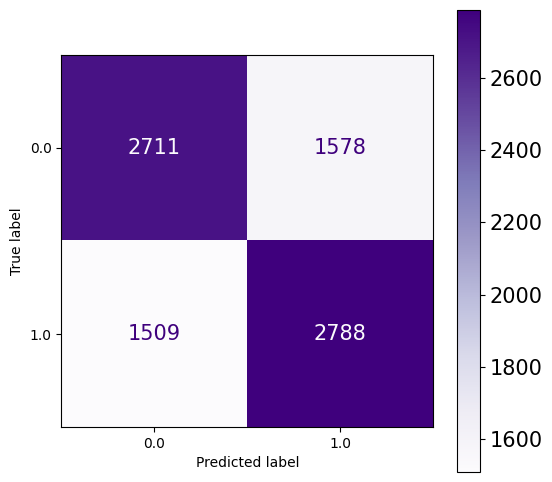

In [ ]:
# Generate confusion matrix
cm = confusion_matrix(test_y, y_pred, labels = loaded_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = loaded_model.classes_)

# Specify figure size and font size
fig, ax = plt.subplots(figsize = (6, 6))
plt.rcParams.update({'font.size': 15})

# Display Confusion Matrix
disp.plot(cmap = 'Purples', ax = ax);

In [ ]:
# Getting prediction probabilites
prob = loaded_model.predict_proba(test_X)

# Printing prediction results
result = pd.DataFrame({'Actual': test_y, 'Predicted': y_pred})

# Creating columns for rejection and acceptance prob.
result[['Reject (0) Prob.','Accept (1) Prob.']] = pd.DataFrame(prob.tolist(), index = result.index)

display(result.head(10))

# Saving dataframe as a csv file
result.to_csv('Prediction Results.csv', index = False)

,Actual,Predicted,Reject (0) Prob.,Accept (1) Prob.
32640,1.0,0.0,0.567132,0.432868
32641,0.0,0.0,0.788792,0.211208
32642,0.0,1.0,0.310353,0.689647
32643,0.0,0.0,0.797890,0.202110
32644,1.0,1.0,0.242225,0.757775
32645,0.0,0.0,0.515793,0.484207
32646,1.0,0.0,0.525415,0.474585
32647,0.0,1.0,0.430130,0.569870
32648,1.0,1.0,0.400459,0.599541
32649,1.0,0.0,0.573720,0.426280


In [ ]:
# Storing importance values from the best fit model
importance = loaded_model.best_estimator_.feature_importances_

In [ ]:
# Displaying feature importance as a dataframe
feature_imp = pd.DataFrame(list(zip(train_X.columns, importance)),
               columns = ['Feature', 'Importance'])

feature_imp = feature_imp.sort_values('Importance', ascending = False).reset_index(drop = True)

feature_imp

,Feature,Importance
0,home_next,0.102715
1,diff_10_x,0.094931
2,diff_10_y,0.094861
3,WIN_10_x,0.060972
4,WIN_10_y,0.058821
5,FG_PCT_opp_10_y,0.033508
6,FG_PCT_opp_10_x,0.031535
7,FG_PCT_10_x,0.030865
8,FG_PCT_10_y,0.030177
9,AST_opp_10_y,0.027514


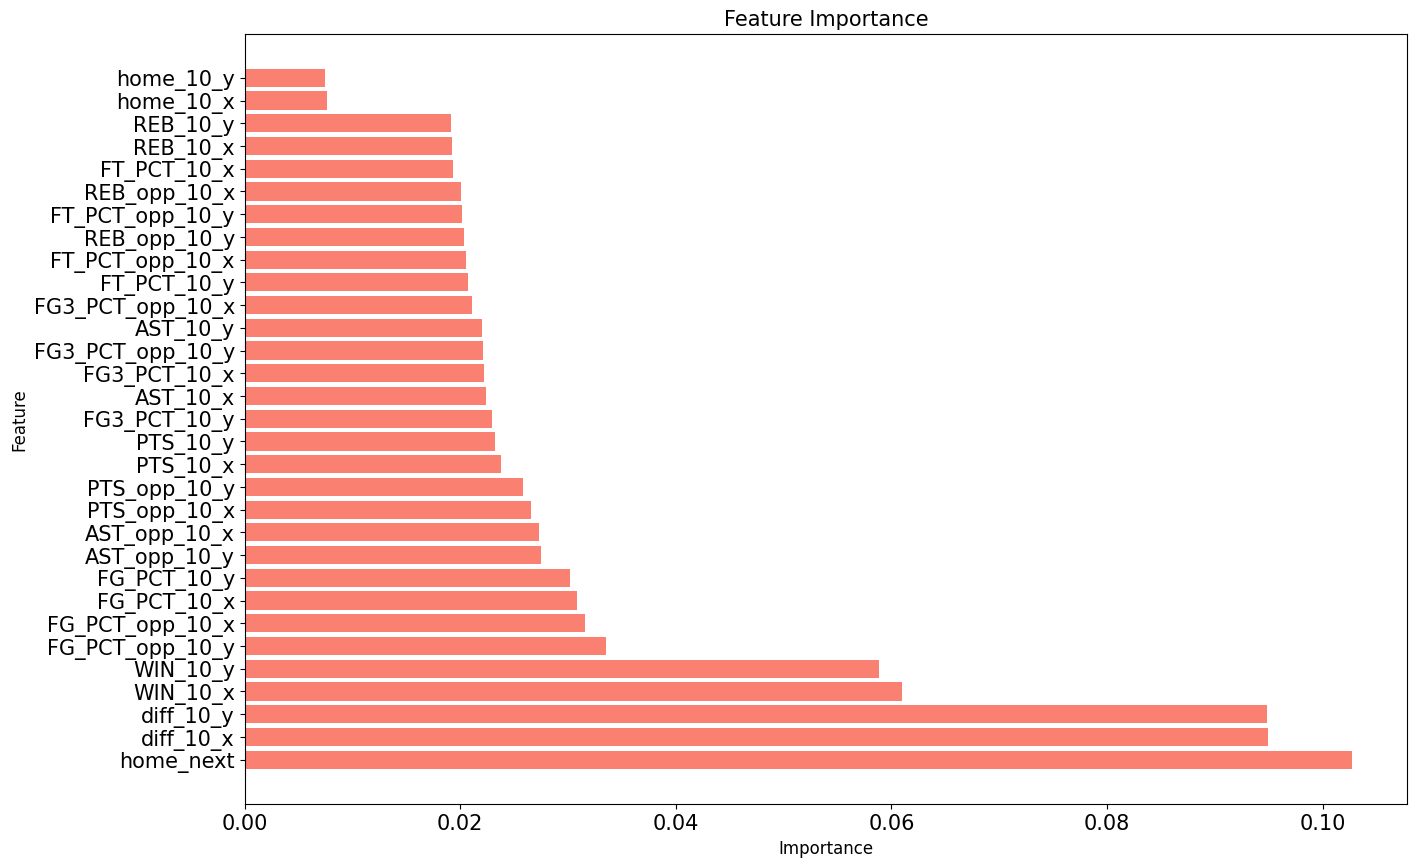

In [ ]:
# Bar plot
plt.figure(figsize=(15, 10), dpi = 100)
plt.barh(feature_imp['Feature'], feature_imp['Importance'], color ='salmon')

plt.xlabel("Importance", fontsize = 12)
plt.ylabel("Feature", fontsize = 12)
plt.title("Feature Importance", fontsize = 15);